In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [2]:
class Simulation:
    def __init__(self, size, nPoints, volFrac = 0.05):
        self.box_size = size
        self.nPoints = nPoints
        self.volume_fraction_threshold = volFrac
        self.__initialize_box()
      
    ################################   The geometry functions   ################################
    @property
    def volume_fraction(self):
        """ 
        Volume fraction as a proportion of non-zero voxels to all voxels in a box
        """
        return int(self.box.sum())/self.nPoints**3
    
    @property
    def density(self):
        """
        Because the box might be changed at any moment density is the copy of it 
        """
        return self.box

    @property
    def FTI(self):
        """
        Set the Fourier transform variable to be the copy of the FT calulated the custom way
        """
        return self.FTI_custom

    def __initialize_box(self):
        """
        Creates a 1D gridding and expands it into a 3D box filled with voxels of size 'grid_space'.
        The box is symmetric around 0 on all axes with the predefined grid points. 
        Calls a function to specify the 3D scattering angle Q

        """
        self.grid = torch.linspace(-self.box_size /2 , self.box_size /2, self.nPoints) 
        self.__expand_Q()
        self.box  = torch.zeros((self.nPoints,self.nPoints,self.nPoints), dtype = torch.float32)
        self.grid_space = self.box_size/(self.nPoints-1)
    
    def __expand_Q(self):
        """
        convert a 1D array to the array of scattering angles and expand it 
        to 3D reciprocal(?) space to get the scattering angle Q in nm-1

        """
        divLength = self.box_size/self.nPoints
        self.qx = torch.linspace(-torch.pi/divLength, torch.pi/divLength, self.nPoints)
        #qy = qx.clone()
        #qz = qx.clone()

        q3x = self.qx + 0 * self.qx[None,:,None] + 0 * self.qx[:,None,None]
        q3y = 0 * self.qx + self.qx[None,:,None] + 0 * self.qx[:,None,None]
        q3z = 0 * self.qx + 0 * self.qx[None,:,None] + self.qx[:,None,None]

        self.Q = torch.sqrt(q3x**2 + q3y**2 + q3z**2)


In [4]:
def safe_multiplier(*args):
    product = 1
    for factor in args:
        if factor !=0:
            product *=factor
    return product 


def safe_dividend( *args):
    fraction = args[0]
    for factor in args[1:]:
        if factor !=0:
            fraction /=factor
    return fraction 

In [3]:
  
class Cylinder(Simulation):
    def __init__(self,size, nPoints, volFrac = 0.05):
        Simulation.__init__(self, size, nPoints, volFrac)  
        self.hWidth = None
        self.hMean = None
        self.rWidth = None
        self.rMean = None
        self.center = None  
        self.shape = 'cylinder'

    def place_shape(self, single = False, **kwargs):
        """
        Updates the Cylinder attributes and places one or many cylinders into the box. If the standard deviation for hight and radius are not defined, sets the default values.
        """
        keys = ['rMean', 'rWidth', 'hMean', 'hWidth', 'center']
        self.__dict__.update((k, v) for k, v in kwargs.items() if k in keys)
        if self.rWidth is None:
            self.rWidth = 0.1
        if self.hWidth is None:
            self.hWidth = 0.15
        self.__cylinder_in_box(single)
    
    def __cylinder_in_box(self,single):
        """
        
        Given a box fill it with cylinder(s). Cylinder must fit into box, otherwise it is discarded until a fitting one is sampled.
        Box might fit many cylinder if the volume fractuion is too small, unless the 'single' argument is specified.
        Calls the generate_cylinder function that creates cylinders as slices.
        Radius Mean and Hight Mean are sampled from normal distribution or were specified when instantiating a Cylinder object.
        Cylinder radius and height are sampled from a normal distribution around the respective Means. 
        Center is sampled from the uniform distribution or was specified for a single cylinder.
        Theta angle is sampled to indicate rotation between the cylinder axis to the beam  and Phi to indicate the  rotation about the beam.
        input:
            single[boolean] : create a single sphere in a box?        
        """
        self.theta = np.random.uniform(low = 0, high = 45)
        self.phi = np.random.uniform(low = 0, high = 45)
        
        
        if self.rMean is None:
            self.rMean = -1
            while self.rMean<=0:
                self.rMean = np.random.normal(loc = self.box_size*0.02, scale= self.box_size*0.05 )
                print('rMean',self.rMean)

        if self.hMean is None:
            self.hMean = -1
            while self.hMean<=0:
                self.hMean = np.random.normal(loc = self.box_size*0.65, scale= self.box_size*0.1 )
        attempt = 0
        if single:
            success = False
            while success == False and attempt <100:
                if self.center is not None and (not ((self.center >self.box_size/2)|(self.center<-self.box_size/2) == True).any()):
                    continue # center was passed and is inside box
                else:
                    self.center = np.random.uniform(low = -self.box_size/2 + self.rMean, high = self.box_size/2 - self.rMean, size = 3)
                success = self.__generate_cylinder(self.rMean, self.hMean, self.center)
                if success ==False:
                    self.center = None
                attempt==1
            print('volume fraction is {vf:.5f}, height is {h:.2f}, radius is {r:.2f}, center at ({cx:.1f},{cy:.1f},{cz:.1f}) '
                .format(vf = self.volume_fraction, h = self.hMean, r = self.rMean, cx=self.center[0], cy = self.center[1], cz = self.center[2]))
        else:
            while self.volume_fraction<self.volume_fraction_threshold and attempt <100:
                success = False
                while success == False:
                    height = np.random.normal(loc = self.hMean, scale= self.hWidth)
                    radius = np.random.normal(loc = self.rMean, scale= self.rWidth )
                    center = np.random.uniform(low = -self.box_size/2, high = self.box_size/2, size = 3)
                    if ((center >self.box_size/2)|(center<-self.box_size/2) == True).any() or (radius <0) or (height <0):
                        continue # center is outside of box or radius or height is negatibve
                    success = self.__generate_cylinder(radius, height, center)
                    if success:
                        print('volume fraction is {vf:.5f}, height is {h:.3f}, radius is {r:.3f}, center at ({cx:.1f},{cy:.1f},{cz:.1f}) '
                        .format(vf = self.volume_fraction, h = height, r = radius, cx=center[0], cy = center[1], cz = center[2]))
                    attempt==1

    
    def __create_slice(self, height, r_theta,r_phi, center, d, capping, direction_right, check):
        """
        FIXME description
        """
        if direction_right:
            center_y = center[1] + safe_multiplier(d,np.tan(np.deg2rad(self.phi))) if self.phi !=0 else center[1] # because of the theta rotation the y-coordinate of center at fixed x  slice shifts
            center_z = center[2] + safe_multiplier(d,np.tan(np.deg2rad(self.theta))) if self.theta !=0 else center[2] # because of phi rotation the z-coordinate of center at fixed x shifts

        else:
            center_y = center[1] - safe_multiplier(d,np.tan(np.deg2rad(self.phi))) if self.phi !=0 else center[1]
            center_z = center[2] - safe_multiplier(d,np.tan(np.deg2rad(self.theta))) if self.theta !=0 else center[2] 
        x2y = self.grid[None,:]
        x2z = self.grid[:,None]
        mask = ((x2y-center_y)**2/r_phi**2 + (x2z-center_z)**2/r_theta**2 <=1).type(torch.bool)
        mask_sum = mask.sum()
        if check:
            if float(mask.sum()) ==0 or (mask[0,:] == True).any() or (mask[-1,:] == True).any() or (mask[:,0] == True).any() or (mask[:, -1] == True).any():
                return torch.zeros_like(mask), True # check_failed
        if capping:
            # calculate the distance from the center of cylinder to the capping plane on the cylinder axis - > dependent on both phi and theta
            d_cap = (height/2- safe_dividend(d,np.cos(np.deg2rad(self.theta)),np.cos(np.deg2rad(self.phi)))) 
            c_theta =  safe_dividend(d_cap, np.sin(np.deg2rad(self.theta)))
            c_phi =  safe_dividend(d_cap, np.sin(np.deg2rad(self.phi)))
            #print("r_phi is {r1:.2f} r theta is {r2:.2f}, cap at ({cap_phi:.2f},{cap_theta:.2f})".format(r2 = r_theta, r1 = r_phi,cap_theta = float(cap_theta), cap_phi = float(cap_phi)))

            # if d_cap positiv the cap is bigger than radius else, it's smaller, anyaway, because we then devide by the sinus 
            #if d_cap >0:
            cap_theta = np.abs(float(r_theta+c_theta)) if self.theta !=0 else 0 # AS IN PAGE 2.1
            cap_phi = np.abs(float(r_phi+c_phi)) if self.phi!=0 else 0


            #print("cap recalculated ({cap_phi:.2f},{cap_theta:.2f})".format(cap_theta = float(cap_theta), cap_phi = float(cap_phi)))
            # point A is first on the line = (cap_phi, cap_theta) now figure out point 2
            # say, point B lies on cap_phi and on diameter of ellipse r_phi -> it has the coord (cap_phi, center_z) -> AB = center_z - cap_theta
            #second point on the line is through triangle ABC, C outside of the ellipse, perp to AB: tan (theta) = BC/AB -> 
            # coordinates of C =(cap_phi - tan(theta)*(center_z - cap_theta), center_z)
            #isn't there a mix up in phi and theta?
            first_index_y = center_y - r_phi #int(torch.argwhere(mask.any(axis=0))[0][0])
            last_index_y = center_y + r_phi # int(torch.argwhere(mask.any(axis=0))[0][-1])
            first_index_z = center_z - r_theta # int(torch.argwhere(mask.any(axis=1))[0][0])
            last_index_z = center_z + r_theta #int(torch.argwhere(mask.any(axis=1))[0][-1])
            #print('f_y:({f_y:.2f},{c_z:.2f}), l_y:({l_y:.2f},{c_z:.2f}), f_z:({c_y:.2f},{f_z:.2f}), l_z:({c_y:.2f},{l_z:.2f})'.format(f_y = first_index_y, f_z = first_index_z, l_y = last_index_y, l_z  =last_index_z, c_y = center_y, c_z = center_z))

            if direction_right:
                A = (float(first_index_y + cap_phi), float(first_index_z+cap_theta))
                if self.theta ==0:
                    C =(float(first_index_y + cap_phi), float(last_index_z))
                elif self.phi ==0:
                    C = (float(last_index_y), float(first_index_z+cap_theta))
                else:
                    # maybe also +center
                    C = (float(first_index_y + cap_phi + np.abs(safe_multiplier((first_index_z + cap_theta+(center_z)),np.tan(np.deg2rad(self.theta + self.phi))))), float(center_z ))
                print('A: ({a0:.2f},{a1:.2f}), C: ({c0:.2f},{c1:.2f})'.format(a0 = A[0], a1  =A[1], c0 = C[0], c1 = C[1])) 
                try:
                    line = np.linalg.solve(np.array([[A[0], 1],[C[0],1]]), np.array([A[1],C[1]]))
                    cap_mask = (x2y *line[0]+line[1]>x2z).type(torch.bool)
                    print("Ellipse equation: (x-({y:+.2f}))^2/{r_phi:.2f}^2 +(y -({z:+.2f}))^2/{r_theta:.2f}^2<1, line equation: y > {a:.2f}x{b:+.2f}".format(r_theta = float(r_theta), r_phi = float(r_phi),  y = float(center_y), z = float(center_z), a = line[0], b = line[1]))
                except np.linalg.LinAlgError: # for case theta = 0 the matrix is indeed singular and the line is vertical
                    cap_mask = (x2y<A[0]).type(torch.bool)
                    print("Ellipse equation: (x-({y:+.2f}))^2/{r_phi:.2f}^2 +(y -({z:+.2f}))^2/{r_theta:.2f}^2<1, line equation: x < {x}".format(r_theta = float(r_theta), r_phi = float(r_phi),  y = float(center_y), z = float(center_z), x = A[0]))
                mask = torch.logical_and(mask, cap_mask)
                
            else:            
                A = (float(last_index_y - cap_phi), float(last_index_z-cap_theta))
                if self.theta ==0:
                    C =(float(last_index_y - cap_phi), float(first_index_z))
                elif self.phi ==0:
                    C = (float(first_index_y), float(last_index_z-cap_theta))
                else:
                    C = (float(last_index_y - cap_phi - np.abs(safe_multiplier(last_index_z - cap_theta-(center_z),np.tan(np.deg2rad(self.theta + self.phi))))), float(center_z ))
                print('A: ({a0:.2f},{a1:.2f}), C: ({c0:.2f},{c1:.2f})'.format(a0 = A[0], a1  =A[1], c0 = C[0], c1 = C[1]), cap_phi, cap_theta) 
                try:
                    line = np.linalg.solve(np.array([[A[0], 1],[C[0],1]]), np.array([A[1],C[1]]))
                    cap_mask = (x2y *line[0]+line[1]<x2z).type(torch.bool)
                    print("Ellipse equation: (x-({y:+.2f}))^2/{r_phi:.2f}^2 +(y -({z:+.2f}))^2/{r_theta:.2f}^2<1, line equation: y < {a:.2f}x{b:+.2f}".format(r_theta = float(r_theta), r_phi = float(r_phi),  y = float(center_y), z = float(center_z), a = line[0], b = line[1]))

                except np.linalg.LinAlgError: # for case theta = 0 the matrix is indeed singular and the line is vertical
                    cap_mask = (x2y>A[0]).type(torch.bool)
                    print("Ellipse equation: (x-({y:+.2f}))^2/{r_phi:.2f}^2 +(y -({z:+.2f}))^2/{r_theta:.2f}^2<1, line equation: x > {x}".format(r_theta = float(r_theta), r_phi = float(r_phi),  y = float(center_y), z = float(center_z), x = A[0]))
                mask = torch.logical_and(mask, cap_mask)

        
        return mask, False


    def __generate_cylinder(self, radius, height, center):
        """
        Create a 3D cylinder as 2D slices. The slices are placed at the same distance to each other 
        as the grid inside the slices. Updates  the class attributes `box` and `density`.
        input:
            radius: the radius of cylinder in nm
            center: triple that points to the center of the cylinder
            height: the hight of the cylinder, height/2 when counting from the center
        output:
            boolean: True if a cylinder was  placed in a box, otherwise, if constraints were not met returns False
        """
        central_axis_cylinder_projection_on_x = safe_multiplier(height/2,np.cos(np.deg2rad(self.theta)),np.cos(np.deg2rad(self.phi)))//self.grid_space # projection of central cylinder axis on x-axis
        cylinder_rest_projection_on_x =  safe_multiplier(np.sin(np.deg2rad(self.theta)),np.sin(np.deg2rad(self.phi)),radius)//self.grid_space # projection of the rest of the cylinder after the central axis on x-axis
        cylinder_projection_on_x = math.ceil(central_axis_cylinder_projection_on_x+ cylinder_rest_projection_on_x) # projection of whole cylinder on x-axis
        #print(cylinder_projection_on_x, central_axis_cylinder_projection_on_x, cylinder_rest_projection_on_x)
        radius_at_theta = safe_dividend(radius,np.cos(np.deg2rad(self.theta))) # calculate the radius of ellipse at slice at both rotations
        radius_at_phi = safe_dividend(radius,np.cos(np.deg2rad(self.phi)))
        #print('radius is {r:.2f}, r_phi is {r_phi:.2f} and r_theta is {r_theta:.2f}'.format(r = radius, r_phi = radius_at_phi, r_theta = radius_at_theta))
        # if central slice on grid:
        if len(self.grid[self.grid == center[0]])==1:
            central_slice = int(torch.argwhere(self.grid==center[0])[0,0])# start with the central slice
            if central_slice+cylinder_projection_on_x >self.box.shape[0] or central_slice-cylinder_projection_on_x <0:
                #print('--->outside of x plane')
                return False
            # check if circles at the ends of cylinder are inside the box  
            d = self.grid_space*cylinder_projection_on_x
            capping = True
            circle_1, check_1 = self.__create_slice(height, radius_at_theta,radius_at_phi, center,d, capping, direction_right = True, check = True)# mask the ellipse location
            circle_2, check_2 = self.__create_slice(height, radius_at_theta,radius_at_phi, center,d, capping, direction_right = False, check = True)

            if  check_1 or check_2:
                #print('--->outside on yz-plane')
                return  False
            # all checks done, the latest sphere is not touching the edge of the box or is completelyoutside of it:  cylinder fits the box, fill the densities by slices
            for i in range(cylinder_projection_on_x): # last grid point fully covering the radius is considered , cylinder is symmetric so work in both directions
                d = self.grid_space*i # calculate the distance grom the center to the slice
                capping = i> central_axis_cylinder_projection_on_x-cylinder_rest_projection_on_x 
                mask,_ =self.__create_slice(height, radius_at_theta,radius_at_phi, center, d, capping, direction_right = True, check = False)
                self.box[central_slice+i,mask] = 1 # density inside cylinder
                mask,_ = self.__create_slice(height, radius_at_theta,radius_at_phi, center, d, capping, direction_right = False, check = False)
                self.box[central_slice-i,mask] = 1

        else:
            # if the center of the cylinder in between of two grid points, find those points and do the same in both dierections
            nearest_bigger_ind = int(torch.argwhere(self.grid>center[0])[0,0])
            if nearest_bigger_ind+cylinder_projection_on_x >self.box.shape[0] or nearest_bigger_ind-1-cylinder_projection_on_x <0:
                #print('--->outside of x plane')
                return  False
            # check if circles at the ends of cylinder are inside the box  
            d1 = self.grid_space*cylinder_projection_on_x + self.grid[nearest_bigger_ind]-center[0]
            d2 = self.grid_space*cylinder_projection_on_x + center[0] - self.grid[nearest_bigger_ind-1]
            capping = True
            circle_1,check_1 = self.__create_slice(height, radius_at_theta,radius_at_phi, center, d1, capping, direction_right = True, check = True)
            circle_2,check_2 = self.__create_slice(height, radius_at_theta,radius_at_phi, center, d2, capping, direction_right = False, check = True)        
            if  check_1 or check_2:
                #print('--->outside on yz-plane')
                return False
            # all checks done, cylinder fitsd the box, fill the densities by slices
            for i in range(cylinder_projection_on_x):
                d1 = self.grid_space*i + self.grid[nearest_bigger_ind]-center[0]
                capping = i> central_axis_cylinder_projection_on_x-cylinder_rest_projection_on_x 
                mask,_ = self.__create_slice(height, radius_at_theta,radius_at_phi, center, d1, capping, direction_right = True, check = False)
                self.box[nearest_bigger_ind+i,mask] = 1 # density inside cylinder
                d2 = self.grid_space*i + center[0] - self.grid[nearest_bigger_ind-1]
                mask,_ = self.__create_slice(height, radius_at_theta,radius_at_phi, center, d2, capping, direction_right = False, check = False)
                self.box[nearest_bigger_ind-1-i,mask] = 1
        return True

    def save_data(self,  directory='.', for_SasView = True):
        """
        Saves .dat file. If slice  of 3D Fourier Transform was created only, operates on that slice, otherwise on whole data.
        input:
            directory to save
            for_SasView: boolean, if True converts Q and I to SASView compartible values: Armstrong^-1 for Q and (m*sr)^-1.
        """
        if 'binned_slice' in dir(self):
            data = self.binned_slice
        else:
            data = self.binned_data

        if for_SasView:
            data.assign(Q = data.Q/10, I = data.I/100, ISigma = data.ISigma/100).to_csv(directory+'/polydispersed_cylinders_{r}_{h}.dat'.
            format(r = int(self.rMean*1000), h = int(self.hMean*1000)), header=None, index=None, columns=["Q", "I", "ISigma"])
        else:
            data.to_csv(directory+'/polydispersed_cylinders_{r}_{h}.dat'.
            format(r = int(self.rMean*1000), h = int(self.hMean*1000)), header=None, index=None, columns=["Q", "I", "ISigma"])



In [5]:

def plot_3D_structure(entity, grid, realspace = True, path = None):
    nPoints = entity.shape[0]
    fig = plt.figure(figsize = (10,10))
    ax = plt.axes(projection ='3d')
    values = entity.nonzero()
    xx, yy, zz = values[:,0],values[:,1],values[:,2]
    img = ax.scatter3D(xx, yy, zz, zdir='z', c= entity[xx,yy,zz],  cmap="coolwarm" if realspace else 'Greys', s = 2, marker = 'o')
    ticks = np.linspace(0,nPoints,11)
    labels = np.round(np.linspace(grid.min(), grid.max(),11)).astype('int')  #labels = np.linspace(self.q3x.numpy().min(), self.q3x.numpy().max(),11)
    if realspace:
        img = ax.scatter3D(xx, yy, zz, zdir='z', c= entity[xx,yy,zz],  cmap="coolwarm" , s = 2, marker = 'o')
        ax.set_xlabel('nm')
        ax.set_ylabel('nm')
        ax.set_zlabel('nm')
        title = 'The density in 3D'
    else: # reciprocal
        img = ax.scatter3D(xx, yy, zz, zdir='z', c= np.log(entity[xx,yy,zz]),  cmap="Greys" , s = 2, marker = 'o')
        ax.set_xlabel('$nm^{-1}$')
        ax.set_ylabel('$nm^{-1}$')
        ax.set_zlabel('$nm^{-1}$')
        title = 'Fourier transformed density in 3D'
        plt.colorbar(img) # only include colorbar when showing a FT
    ax.set_xticks(ticks, labels)
    ax.set_yticks(ticks, labels)
    ax.set_zticks(ticks, labels)
    ax.set_xlim(0,nPoints)
    ax.set_ylim(0,nPoints)
    ax.set_zlim(0,nPoints)
    if path:
        plt.savefig(path)
        plt.close()
    else:
        plt.title(title)# only set title when not saving a file
        plt.show()


In [6]:
simulation = Simulation(size = 10, nPoints = 251, volFrac = 0.01)

In [44]:
# sample values to construt cylinder
theta = np.random.uniform(low = 0, high = 45)
phi = np.random.uniform(low = 0, high = 45)

rMean = np.random.normal(loc = simulation.box_size*0.2, scale= simulation.box_size*0.05 )
hMean = np.random.normal(loc = simulation.box_size*0.45, scale= simulation.box_size*0.1 )
center = np.random.uniform(low = (-simulation.box_size/2 + rMean)//2, high = (simulation.box_size/2 - rMean)//2, size = 3)
print(theta, phi, rMean, hMean, center)

24.163006975565924 18.392262906205058 1.43396099765187 4.676645869116929 [ 0.53980749 -1.091617    0.55350364]


In [45]:
radius = rMean
height = hMean

In [46]:
central_axis_cylinder_projection_on_x = safe_multiplier(height/2,np.cos(np.deg2rad(theta)),np.cos(np.deg2rad(phi)))//simulation.grid_space # projection of central cylinder axis on x-axis
cylinder_rest_projection_on_x =  safe_multiplier(np.sin(np.deg2rad(theta)),np.sin(np.deg2rad(phi)),radius)//simulation.grid_space # projection of the rest of the cylinder after the central axis on x-axis
cylinder_projection_on_x = math.ceil(central_axis_cylinder_projection_on_x+ cylinder_rest_projection_on_x) # projection of whole cylinder on x-axis
#print(cylinder_projection_on_x, central_axis_cylinder_projection_on_x, cylinder_rest_projection_on_x)
radius_at_theta = safe_dividend(radius,np.cos(np.deg2rad(theta))) # calculate the radius of ellipse at slice at both rotations
radius_at_phi = safe_dividend(radius,np.cos(np.deg2rad(phi)))

In [62]:
radius_at_theta, radius_at_phi,cylinder_projection_on_x

(1.5716628808144057, 1.51115275435272, 54)

In [47]:
nearest_bigger_ind = int(torch.argwhere(simulation.grid>center[0])[0,0])

In [81]:
def slice_plotter(i,r_phi,r_theta):
    d1 = simulation.grid_space*i + simulation.grid[nearest_bigger_ind]-center[0]
    capping = i> central_axis_cylinder_projection_on_x-cylinder_rest_projection_on_x 
    print('the distance is {d:.2f}'.format(d = d1)) 
    center_y = center[1] + safe_multiplier(d1,np.tan(np.deg2rad(phi))) if phi !=0 else center[1] # because of the theta rotation the y-coordinate of center at fixed x  slice shifts
    center_z = center[2] + safe_multiplier(d1,np.tan(np.deg2rad(theta))) if theta !=0 else center[2] # because of phi rotation the z-coordinate of center at fixed x shifts

    x2y = simulation.grid[None,:]
    x2z = simulation.grid[:,None]
    mask = ((x2y-center_y)**2/r_phi**2 + (x2z-center_z)**2/r_theta**2 <=1).type(torch.bool)
    mask_capped = torch.zeros_like(mask)
    if capping:
        # calculate the distance from the center of cylinder to the capping plane on the cylinder axis - > dependent on both phi and theta
        d_cap = (height/2- safe_dividend(d1,np.cos(np.deg2rad(theta)),np.cos(np.deg2rad(phi)))) 
        c_theta =  safe_dividend(d_cap, np.sin(np.deg2rad(theta)))
        c_phi =  safe_dividend(d_cap, np.sin(np.deg2rad(phi)))
        print('d_cap is {d:.2f}, cap_theta is {ct:.2f} and cap_phi is {cp:.2f}'.format(d = d_cap, ct = c_theta,cp = c_phi)) 
        #print("r_phi is {r1:.2f} r theta is {r2:.2f}, cap at ({cap_phi:.2f},{cap_theta:.2f})".format(r2 = r_theta, r1 = r_phi,cap_theta = float(cap_theta), cap_phi = float(cap_phi)))

        # if d_cap positiv the cap is bigger than radius else, it's smaller, anyaway, because we then devide by the sinus 
        #if d_cap >0:
        cap_theta = np.abs(float(r_theta+c_theta)) if theta !=0 else 0 # AS IN PAGE 2.1
        cap_phi = np.abs(float(r_phi+c_phi)) if phi!=0 else 0

        print(' cap_theta is {ct:.2f} and cap_phi is {cp:.2f}'.format(d = d_cap, ct = cap_theta,cp = cap_phi)) 
        first_index_y = center_y - r_phi #int(torch.argwhere(mask.any(axis=0))[0][0])
        last_index_y = center_y + r_phi # int(torch.argwhere(mask.any(axis=0))[0][-1])
        first_index_z = center_z - r_theta # int(torch.argwhere(mask.any(axis=1))[0][0])
        last_index_z = center_z + r_theta #int(torch.argwhere(mask.any(axis=1))[0][-1])
        #print('f_y:({f_y:.2f},{c_z:.2f}), l_y:({l_y:.2f},{c_z:.2f}), f_z:({c_y:.2f},{f_z:.2f}), l_z:({c_y:.2f},{l_z:.2f})'.format(f_y = first_index_y, f_z = first_index_z, l_y = last_index_y, l_z  =last_index_z, c_y = center_y, c_z = center_z))

        A = (float(first_index_y + cap_phi), float(first_index_z+cap_theta))
        if theta ==0:
            C =(float(first_index_y + cap_phi), float(last_index_z))
        elif phi ==0:
            C = (float(last_index_y), float(first_index_z+cap_theta))
        else:
            C = (float(first_index_y + cap_phi + np.abs(safe_multiplier((first_index_z + cap_theta+(center_z)),np.tan(np.deg2rad(theta + phi))))), float(center_z ))
        try:
            line = np.linalg.solve(np.array([[A[0], 1],[C[0],1]]), np.array([A[1],C[1]]))
            cap_mask = (x2y *line[0]+line[1]>x2z).type(torch.bool)
        except np.linalg.LinAlgError: # for case theta = 0 the matrix is indeed singular and the line is vertical
            cap_mask = (x2y<A[0]).type(torch.bool)
        mask_capped = torch.logical_and(mask, cap_mask)
        print('A: ({a0:.2f},{a1:.2f}), C: ({c0:.2f},{c1:.2f})'.format(a0 = A[0], a1  =A[1], c0 = C[0], c1 = C[1]), cap_phi, cap_theta) 
        print("Ellipse equation: (x-({y:+.2f}))^2/{r_phi:.2f}^2 +(y -({z:+.2f}))^2/{r_theta:.2f}^2<1, line equation: y > {a:.2f}x{b:+.2f}".format(r_theta = float(r_theta), r_phi = float(r_phi),  y = float(center_y), z = float(center_z), a = line[0], b = line[1]))

    
    fig,axs = plt.subplots(1,4,figsize = (20,10))
    ax = axs[0]
    im = ax.imshow(mask)
    ax.set_title('mask right')
    ax = axs[1]
    im = ax.imshow(mask_capped)
    ax.set_title('capped mask right')
     
    d2 = simulation.grid_space*i + center[0] - simulation.grid[nearest_bigger_ind-1]
    
    print('the distance is {d:.2f}'.format(d = d2)) 
    center_y = center[1] - safe_multiplier(d2,np.tan(np.deg2rad(phi))) if phi !=0 else center[1]
    center_z = center[2] - safe_multiplier(d2,np.tan(np.deg2rad(theta))) if theta !=0 else center[2] 
    mask = ((x2y-center_y)**2/r_phi**2 + (x2z-center_z)**2/r_theta**2 <=1).type(torch.bool)
    mask_capped = torch.zeros_like(mask)

    if capping:
        d_cap = (height/2- safe_dividend(d2,np.cos(np.deg2rad(theta)),np.cos(np.deg2rad(phi)))) 
        c_theta =  safe_dividend(d_cap, np.sin(np.deg2rad(theta)))
        c_phi =  safe_dividend(d_cap, np.sin(np.deg2rad(phi)))
        #print("r_phi is {r1:.2f} r theta is {r2:.2f}, cap at ({cap_phi:.2f},{cap_theta:.2f})".format(r2 = r_theta, r1 = r_phi,cap_theta = float(cap_theta), cap_phi = float(cap_phi)))
        print('d_cap is {d:.2f}, cap_theta is {ct:.2f} and cap_phi is {cp:.2f}'.format(d = d_cap, ct = c_theta,cp = c_phi)) 
        # if d_cap positiv the cap is bigger than radius else, it's smaller, anyaway, because we then devide by the sinus 
        #if d_cap >0:
        cap_theta = np.abs(float(r_theta+c_theta)) if theta !=0 else 0 # AS IN PAGE 2.1
        cap_phi = np.abs(float(r_phi+c_phi)) if phi!=0 else 0

        print(' cap_theta is {ct:.2f} and cap_phi is {cp:.2f}'.format(d = d_cap, ct = cap_theta,cp = cap_phi)) 
        first_index_y = center_y - r_phi #int(torch.argwhere(mask.any(axis=0))[0][0])
        last_index_y = center_y + r_phi # int(torch.argwhere(mask.any(axis=0))[0][-1])
        first_index_z = center_z - r_theta # int(torch.argwhere(mask.any(axis=1))[0][0])
        last_index_z = center_z + r_theta #int(torch.argwhere(mask.any(axis=1))[0][-1])
        
        A = (float(last_index_y - cap_phi), float(last_index_z-cap_theta))
        if theta ==0:
            C =(float(last_index_y - cap_phi), float(first_index_z))
        elif phi ==0:
            C = (float(first_index_y), float(last_index_z-cap_theta))
        else:
            C = (float(last_index_y - cap_phi - np.abs(safe_multiplier(last_index_z - cap_theta-(center_z),np.tan(np.deg2rad(theta + phi))))), float(center_z ))
        try:
            line = np.linalg.solve(np.array([[A[0], 1],[C[0],1]]), np.array([A[1],C[1]]))
            cap_mask = (x2y *line[0]+line[1]<x2z).type(torch.bool)

        except np.linalg.LinAlgError: # for case theta = 0 the matrix is indeed singular and the line is vertical
            cap_mask = (x2y>A[0]).type(torch.bool)
        mask_capped = torch.logical_and(mask, cap_mask)
        print('A: ({a0:.2f},{a1:.2f}), C: ({c0:.2f},{c1:.2f})'.format(a0 = A[0], a1  =A[1], c0 = C[0], c1 = C[1]), cap_phi, cap_theta) 
        print("Ellipse equation: (x-({y:+.2f}))^2/{r_phi:.2f}^2 +(y -({z:+.2f}))^2/{r_theta:.2f}^2<1, line equation: y > {a:.2f}x{b:+.2f}".format(r_theta = float(r_theta), r_phi = float(r_phi),  y = float(center_y), z = float(center_z), a = line[0], b = line[1]))

    ax = axs[2]
    im = ax.imshow(mask)
    ax.set_title('mask left')
    ax = axs[3]
    im = ax.imshow(mask_capped)
    ax.set_title('capped mask left')

False


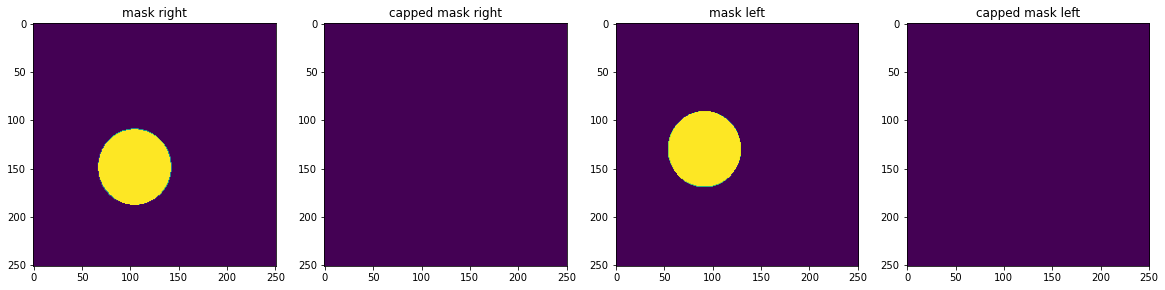

In [49]:
slice_plotter(20, radius_at_phi, radius_at_theta)

the distance is 1.90
d_cap is 1.11, cap_theta is 1.11 and cap_phi is 1.11
 cap_theta is 2.68 and cap_phi is 2.62
A: (0.65,2.52), C: (4.25,1.41) 2.6225781440734863 2.6830883026123047
the distance is 1.90
d_cap is 1.11, cap_theta is 1.11 and cap_phi is 1.11
 cap_theta is 2.69 and cap_phi is 2.63
A: (-2.84,-1.41), C: (-3.86,-0.30) 2.626020908355713 2.6865310668945312


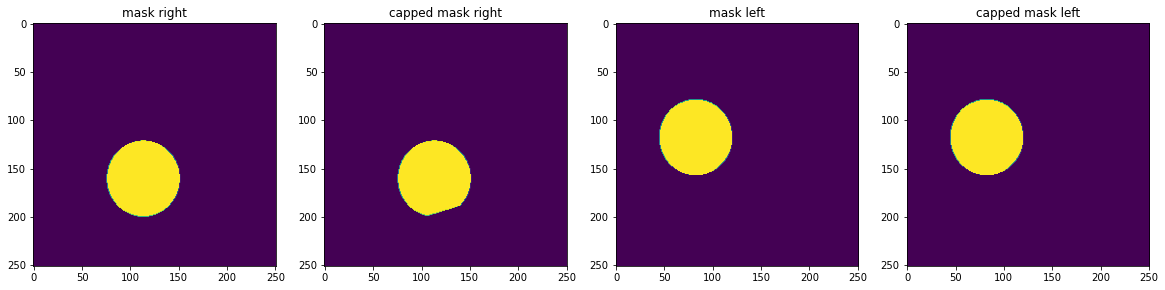

In [82]:
slice_plotter(47, radius_at_phi, radius_at_theta)

the distance is 1.94
d_cap is 0.75, cap_theta is 0.75 and cap_phi is 0.75
 cap_theta is 2.33 and cap_phi is 2.26
A: (0.31,2.18), C: (3.61,1.42) 2.264854669570923 2.325364828109741
the distance is 1.94
d_cap is 0.76, cap_theta is 0.76 and cap_phi is 0.76
 cap_theta is 2.33 and cap_phi is 2.27
A: (-2.49,-1.07), C: (-3.19,-0.32) 2.2682993412017822 2.3288094997406006


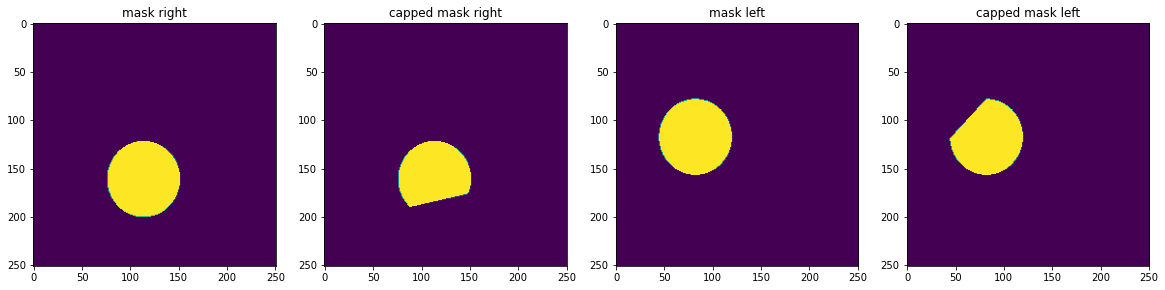

In [83]:
slice_plotter(48, radius_at_phi, radius_at_theta)

the distance is 1.98
d_cap is 0.40, cap_theta is 0.40 and cap_phi is 0.40
 cap_theta is 1.97 and cap_phi is 1.91
the distance is 1.98
d_cap is 0.40, cap_theta is 0.40 and cap_phi is 0.40
 cap_theta is 1.97 and cap_phi is 1.91


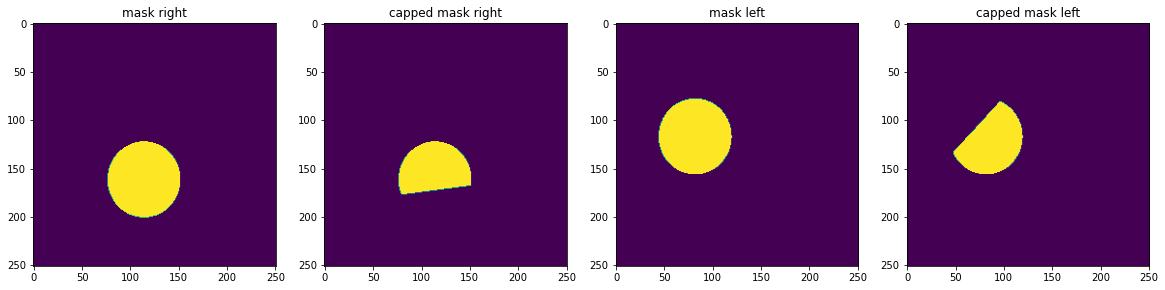

In [78]:
slice_plotter(49, radius_at_phi, radius_at_theta)

the distance is 2.02
d_cap is 0.04, cap_theta is 0.04 and cap_phi is 0.04
 cap_theta is 1.61 and cap_phi is 1.55
the distance is 2.02
d_cap is 0.04, cap_theta is 0.04 and cap_phi is 0.04
 cap_theta is 1.61 and cap_phi is 1.55


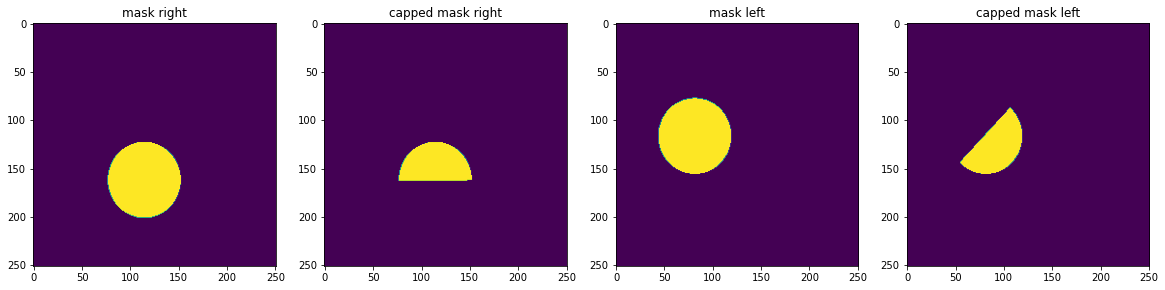

In [79]:
slice_plotter(50, radius_at_phi, radius_at_theta)

the distance is 2.06
d_cap is -0.32, cap_theta is -0.32 and cap_phi is -0.32
 cap_theta is 1.25 and cap_phi is 1.19
the distance is 2.06
d_cap is -0.32, cap_theta is -0.32 and cap_phi is -0.32
 cap_theta is 1.26 and cap_phi is 1.20


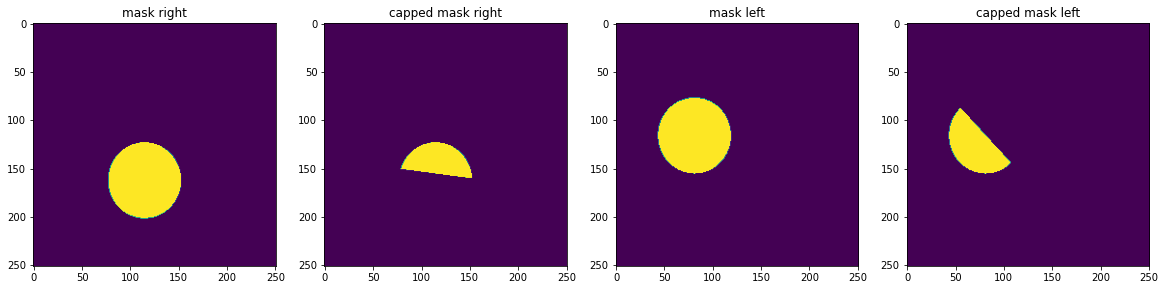

In [80]:
slice_plotter(51, radius_at_phi, radius_at_theta)

True


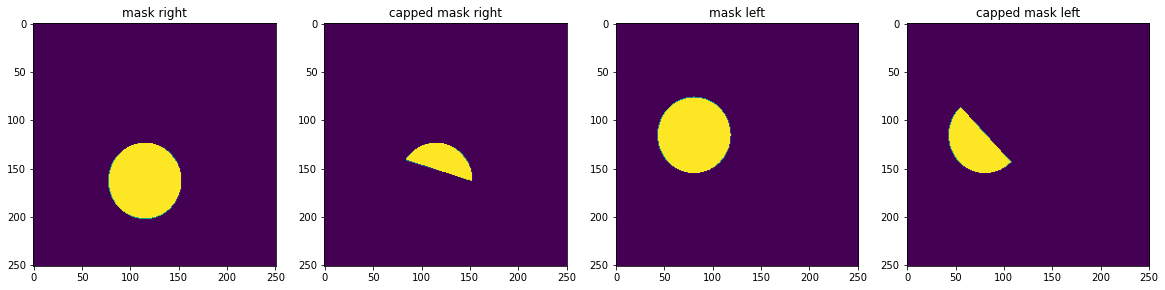

In [60]:
slice_plotter(52, radius_at_phi, radius_at_theta)

tensor(False)


Text(0.5, 1.0, 'capped mask')

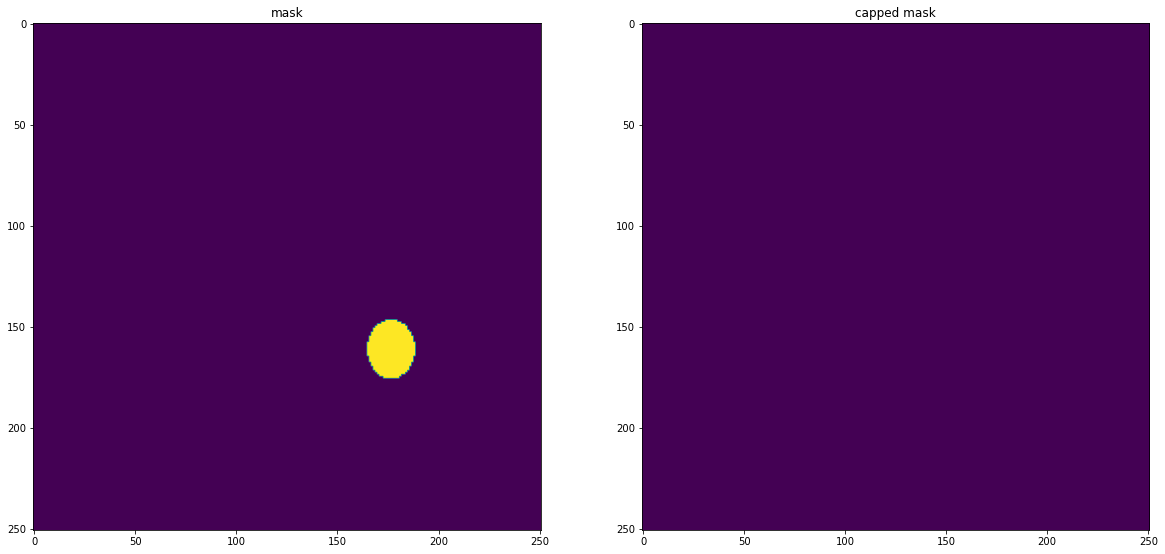

In [23]:
#self.__create_slice(radius,radius_at_slice, center, d1, capping, direction_right = True, check = True)
center_y = center[1] + d1*np.tan(np.deg2rad(theta)) # because of the theta rotation the y-coordinate of center at fixed x  slice shifts
center_z = center[2] + d1*np.tan(np.deg2rad(phi)) # because of phi rotation the z-coordinate of center at fixed x shifts
x2y = simulation.grid[None,:]
x2z = simulation.grid[:,None]
mask = (x2y-center_y)**2/radius**2 + (x2z-center_z)**2/radius_at_slice**2 <=1
print(float(mask.sum()) ==0 or (mask[0,:] == True).any() or (mask[-1,:] == True).any() or (mask[:,0] == True).any() or (mask[:, -1] == True).any())

cap = int(d1*np.tan(np.deg2rad(theta)))
first_index = int(torch.argwhere(mask.any(axis=1))[0][0])
mask_capped = mask.clone()
mask_capped[first_index+cap:,:] = 0

fig,axs = plt.subplots(1,2,figsize = (20,10))
ax = axs[0]
im = ax.imshow(mask)
ax.set_title('mask')
ax = axs[1]
im = ax.imshow(mask_capped)
ax.set_title('capped mask')

In [25]:
np.argwhere(mask.any(axis=0))

tensor([[165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
         179, 180, 181, 182, 183, 184, 185, 186, 187, 188]])

In [98]:
def slice_plotter(i):
    d1 = simulation.grid_space*i + center[0] - simulation.grid[nearest_bigger_ind-1]
    capping = d1> central_axis_cylinder_projection_on_x-cylinder_resy_projection_on_x
    print(capping) 
    center_y = center[1] + d1*np.tan(np.deg2rad(theta)) # because of the theta rotation the y-coordinate of center at fixed x  slice shifts
    center_z = center[2] + d1*np.tan(np.deg2rad(phi)) # because of phi rotation the z-coordinate of center at fixed x shifts
        
    x2y = simulation.grid[None,:]
    x2z = simulation.grid[:,None]
    mask = (x2y-center_y)**2/radius**2 + (x2z-center_z)**2/radius_at_slice**2 <=1
    mask_capped = mask.clone()
    if capping:
        cap = int(d1*np.tan(np.deg2rad(theta)))
        first_index = int(torch.argwhere(mask.any(axis=1))[0][0])
        mask_capped[first_index+cap:,:] = 0


    d2 = simulation.grid_space*i + simulation.grid[nearest_bigger_ind]-center[0]
    capping = d2> central_axis_cylinder_projection_on_x-cylinder_resy_projection_on_x
    print(capping) 
    center_y = center[1] - d2*np.tan(np.deg2rad(theta))
    center_z = center[2] - d2*np.tan(np.deg2rad(phi))
    x2y = simulation.grid[None,:]
    x2z = simulation.grid[:,None]
    mask2 = (x2y-center_y)**2/radius**2 + (x2z-center_z)**2/radius_at_slice**2 <=1
    mask_capped2 = mask2.clone()
    if capping:
        cap = int(d2*np.tan(np.deg2rad(theta)))
        last_index = int(torch.argwhere(mask2.any(axis=1))[0][-1])
        mask_capped2[:last_index - cap,:] = 0

    print(d1,d2)
    fig,axs = plt.subplots(1,4,figsize = (10,5))
    ax = axs[0]
    im = ax.imshow(mask)
    ax.set_title('mask')
    ax = axs[1]
    im = ax.imshow(mask_capped)
    ax.set_title('capped mask')
    ax = axs[2]
    im = ax.imshow(mask2)
    ax.set_title('mask')
    ax = axs[3]
    im = ax.imshow(mask_capped2)
    ax.set_title('capped mask')

tensor(False)


Text(0.5, 1.0, 'capped mask')

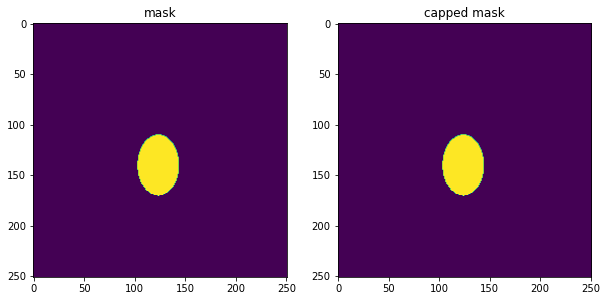

In [74]:
#self.__create_slice(radius,radius_at_slice, center, d1, capping, direction_right = True, check = True)
center_y = center[1] - d2*np.tan(np.deg2rad(theta)) # because of the theta rotation the y-coordinate of center at fixed x  slice shifts
center_z = center[2] - d2*np.tan(np.deg2rad(phi)) # because of phi rotation the z-coordinate of center at fixed x shifts
x2y = simulation.grid[None,:]
x2z = simulation.grid[:,None]
mask = (x2y-center_y)**2/radius**2 + (x2z-center_z)**2/radius_at_slice**2 <=1
print(float(mask.sum()) ==0 or (mask[0,:] == True).any() or (mask[-1,:] == True).any() or (mask[:,0] == True).any() or (mask[:, -1] == True).any())

cap = int(d2*np.tan(np.deg2rad(theta)))
last_index = int(torch.argwhere(mask.any(axis=1))[0][-1])
mask_capped = mask.clone()
mask_capped[:last_index - cap,:] = 0

fig,axs = plt.subplots(1,2,figsize = (10,10))
ax = axs[0]
im = ax.imshow(mask)
ax.set_title('mask')
ax = axs[1]
im = ax.imshow(mask_capped)
ax.set_title('capped mask')

In [103]:
simulation.grid_space*10  + center[0] -simulation.grid[nearest_bigger_ind-1]

0.4

tensor(-0.1600)

In [1]:
slice_plotter(0)

NameError: name 'slice_plotter' is not defined

tensor(False)
tensor(False)


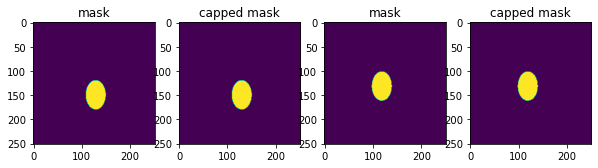

In [86]:
slice_plotter(10)

tensor(False)
tensor(False)


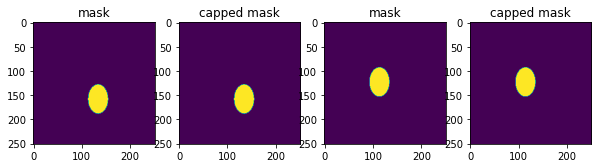

In [87]:
slice_plotter(20)

tensor(False)
tensor(False)


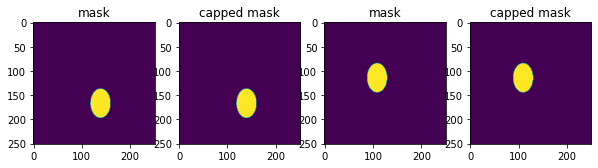

In [88]:
slice_plotter(30)

tensor(False)
tensor(False)


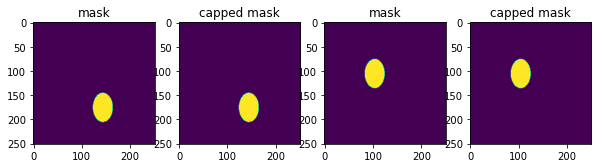

In [89]:
slice_plotter(40)

tensor(False)
tensor(False)
tensor(5.6257) tensor(5.6143)


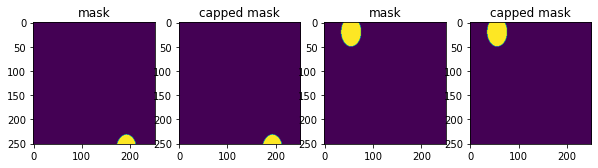

In [101]:
slice_plotter(140)

In [102]:
d2,central_axis_cylinder_projection_on_x-cylinder_resy_projection_on_x

(tensor(0.0143), 53.54983526410582)

In [ ]:

# if the center of the cylinder in between of two grid points, find those points and do the same in both dierections
nearest_bigger_ind = int(torch.argwhere(self.grid>center[0])[0,0])
if nearest_bigger_ind+cylinder_projection_on_x >self.box.shape[0] or nearest_bigger_ind-1-cylinder_projection_on_x <0:
    print('--->outside of x plane')
    return  False
# check if circles at the ends of cylinder are inside the box  
d1 = self.grid_space*cylinder_projection_on_x + center[0] - self.grid[nearest_bigger_ind-1]
d2 = self.grid_space*cylinder_projection_on_x + self.grid[nearest_bigger_ind]-center[0]
capping = True
circle_1,check_1 = self.__create_slice(radius,radius_at_slice, center, d1, capping, direction_right = True, check = True)
circle_2,check_2 = self.__create_slice(radius,radius_at_slice, center, d2, capping, direction_right = False, check = True)        
if  check_1 or check_2:
    print('--->outside on yz-plane')
    return False
# all checks done, cylinder fitsd the box, fill the densities by slices
for i in range(cylinder_projection_on_x):
    d1 = self.grid_space*i + center[0] - self.grid[nearest_bigger_ind-1]
    capping = True if d1> central_axis_cylinder_projection_on_x-cylinder_projection_on_x else False
    mask,_ = self.__create_slice(radius,radius_at_slice, center, d1, capping, direction_right = True, check = False)
    plt.imshow(mask)
    self.box[nearest_bigger_ind+i,mask] = 1 # density inside cylinder
    d2 = self.grid_space*i + self.grid[nearest_bigger_ind]-center[0]
    capping = True if d2> central_axis_cylinder_projection_on_x-cylinder_projection_on_x else False
    mask,_ = self.__create_slice(radius,radius_at_slice, center, d2, capping, direction_right = False, check = False)
    plt.imshow(mask)
    self.box[nearest_bigger_ind-1+i,mask] = 1

volume fraction is 0.00254, height is 3.49, radius is 0.65, center at (2.4,0.2,-1.6) 
47.602678414705046 19.374689828404303


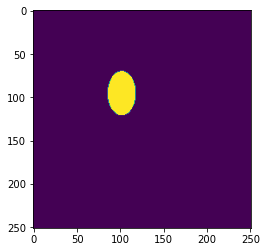

In [14]:

simulation = Cylinder(size = 10, nPoints = 251, volFrac = 0.01)
simulation.place_shape(single = True)
print(simulation.theta, simulation.phi)

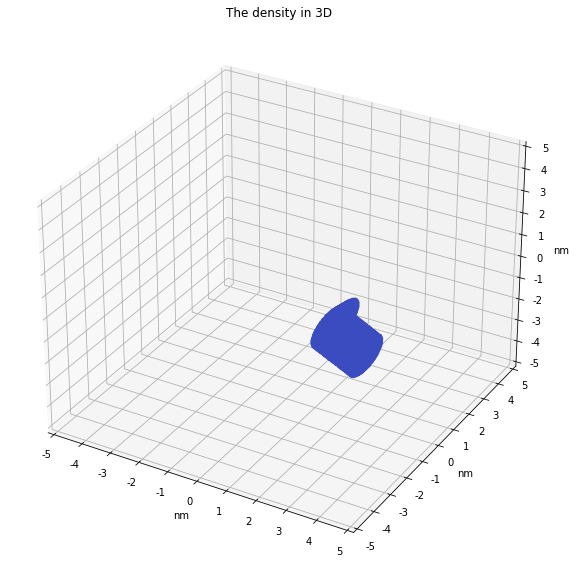

In [15]:
plot_3D_structure(simulation.density, simulation.grid, realspace=True)

In [64]:
grid = np.linspace(-2,2,200)
mask = np.zeros((grid.shape[0],grid.shape[0]), dtype = 'bool')
x2x = grid[None,:]
x2y = grid[:,None]
center = (0.2,-1)
circle = (x2x-center[0])**2 + (x2y-center[1])**2 < 0.8**2
mask[circle] = 1

In [65]:
# say the line is given by: 100+2x
line = x2x*1.2-20

In [68]:
lineline = (x2x *(1.2)-0.1>x2y).astype('bool')

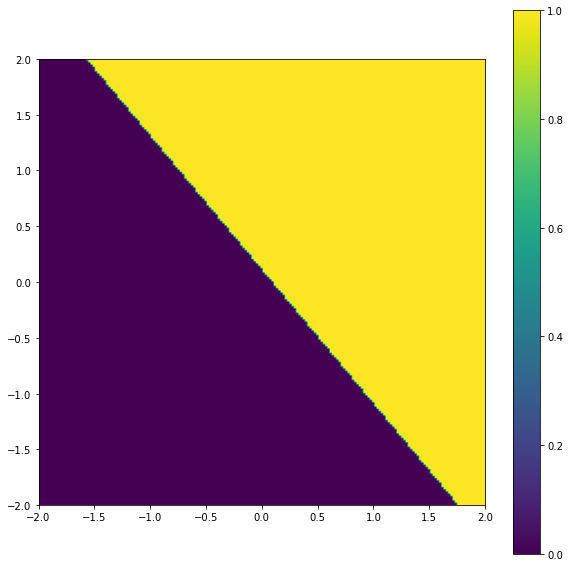

In [69]:
plt.figure(figsize = (10,10))
img = plt.imshow(lineline,extent=[grid.min(), grid.max(), grid.min(), grid.max()])
plt.colorbar()

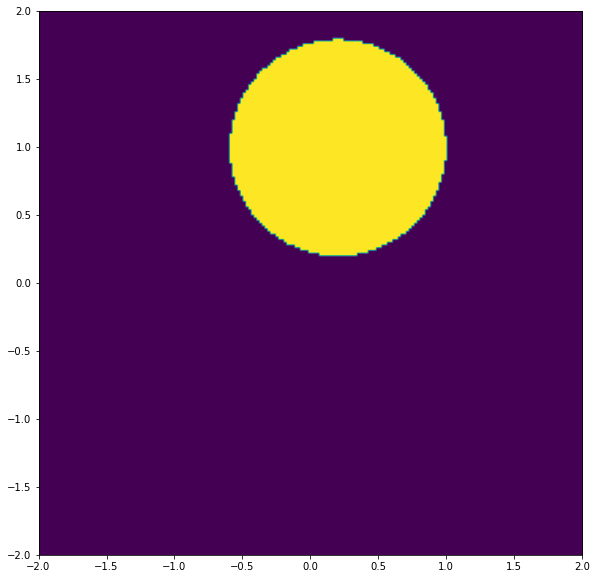

In [70]:
plt.figure(figsize = (10,10))
plt.imshow(mask, extent=[grid.min(), grid.max(), grid.min(), grid.max()])

In [71]:
capped_mask = np.logical_and(mask, lineline)

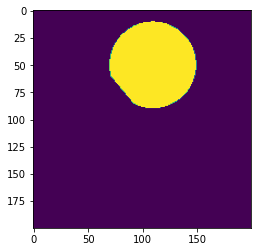

In [72]:
plt.imshow(capped_mask)

In [2]:
from skspatial.objects import Cylinder as clndr
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import torch

"ticks = np.linspace(0,100,11)\nlabels = np.round(np.linspace(x.min(), x.max(),11)).astype('int')  #labels = np.linspace(self.q3x.numpy().min(), self.q3x.numpy().max(),11)\n\nax.set_xticks(ticks, labels);\nax.set_yticks(ticks, labels);\nax.set_zticks(ticks, labels);"

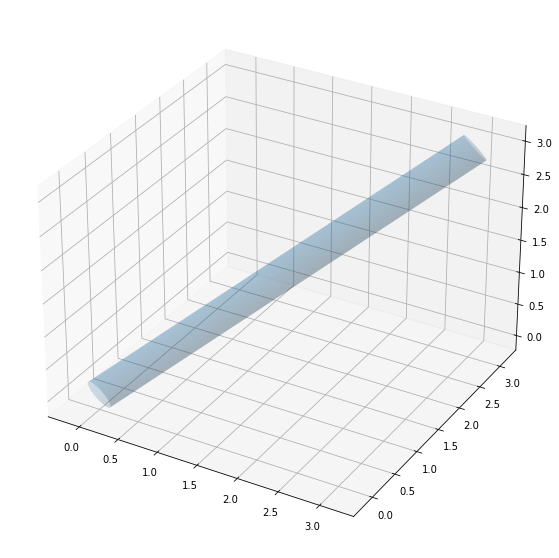

In [40]:
fig = plt.figure( figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
cylinder = clndr([0,0,0], [3,3,3], 0.2)
cylinder.plot_3d(ax, 100,100, alpha=0.2)
'''ticks = np.linspace(0,100,11)
labels = np.round(np.linspace(x.min(), x.max(),11)).astype('int')  #labels = np.linspace(self.q3x.numpy().min(), self.q3x.numpy().max(),11)

ax.set_xticks(ticks, labels);
ax.set_yticks(ticks, labels);
ax.set_zticks(ticks, labels);'''
#cylinder.point.plot_3d(ax, s=100)

In [32]:

import numpy as np
x = np.linspace(-5,5,501)
y = np.linspace(-5,5,501)
z = np.linspace(-5,5,501)
arr = np.vstack(np.meshgrid(x, y, z)).reshape(3,-1).T

In [35]:
coords = np.array(np.meshgrid(x, y, z))
coordsArr = np.vstack(coords).reshape(3,-1).T
density = np.zeros(coords.shape[1:])
kansas=density.shape
# lindensity = density.reshape(1, -1)

In [11]:
def points_in_cylinder(pt1, pt2, r, q):
    vec = pt2 - pt1
    const = r * np.linalg.norm(vec)
    return np.array(
        (np.dot(q - pt1, vec) >= 0) * 
        (np.dot(q - pt2, vec) <= 0) *
        (np.linalg.norm(np.cross(q - pt1, vec), axis=1) <= const),
        dtype=float
        )

In [41]:
lindensity2 = points_in_cylinder(pt1 = np.array([0, -3, -3]), pt2 = np.array([0, 3, 3]), r=1, q=coordsArr)
density2 = np.array(lindensity2).reshape(kansas)

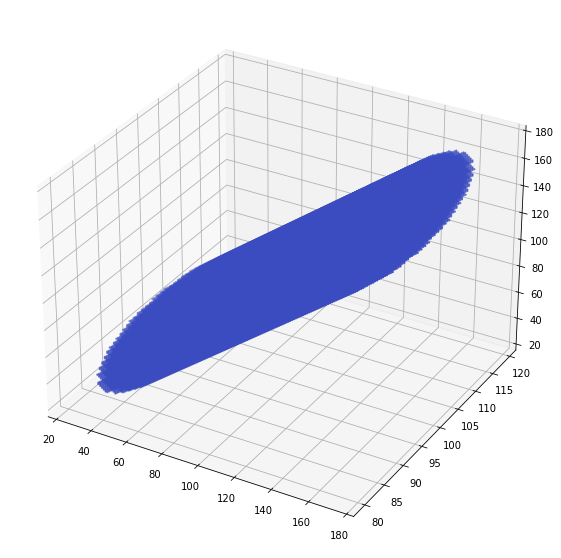

In [34]:

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection ='3d')
values = density2.nonzero()
xx, yy, zz = values[0],values[1],values[2]
img = ax.scatter3D(xx, yy, zz, zdir='z', c= density2[xx,yy,zz],  cmap="coolwarm" , s = 2, marker = 'o')

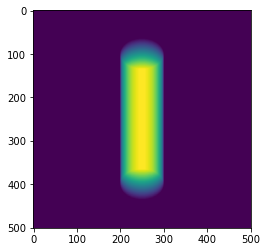

In [44]:
import matplotlib.pyplot as plt
plt.imshow(density2.sum(axis=2))

In [68]:
g = np.meshgrid( y, z)
positions = np.vstack(map(np.ravel, g)).T
def position_to_mesh(index, mesh1D):
    y_pos = index//len(mesh1D)
    x_pos = index - y_pos*len(mesh1D)
    return x_pos,y_pos

/tmp/ipykernel_10858/3458731571.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  positions = np.vstack(map(np.ravel, g)).T


In [15]:
def check_density(x, y, z, cylinder):
    density = np.zeros((len(x),len(x),len(x)))
    for i, x_i in enumerate(x):
        for j, y_j  in enumerate(y):
            for k, z_k in enumerate(z):
                density[i,j,k] = cylinder.is_point_within([x_i, y_j, z_k])
    return density

In [16]:
density = check_density(x, y, z, cylinder)

In [17]:
d = torch.from_numpy(density)

In [18]:
plot_3D_structure(simulation.density, x, realspace=True)

NameError: name 'plot_3D_structure' is not defined

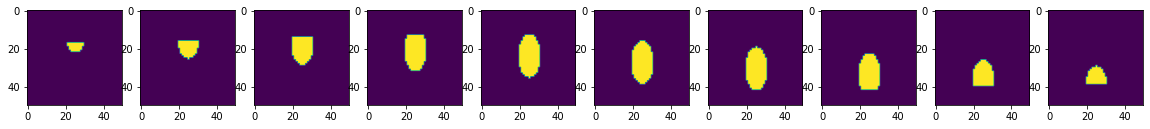

In [ ]:
plot_slices_at_interval(2, 17, simulation, 'z')

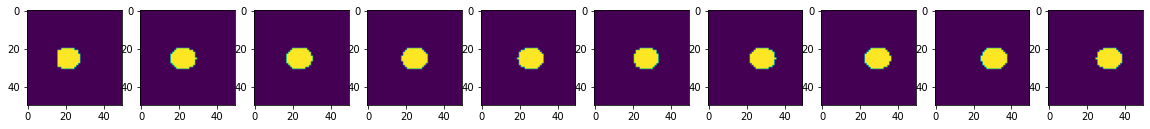

In [ ]:
plot_slices_at_interval(2, 17, simulation, 'x')

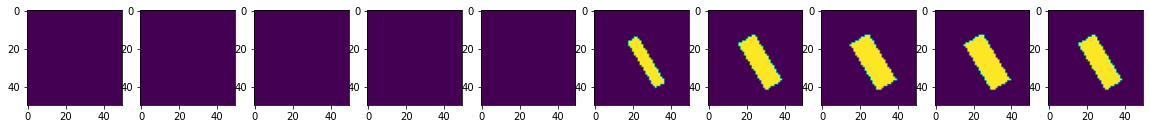

In [ ]:
plot_slices_at_interval(2, 10, simulation, 'y')

In [119]:
from SAXSsimulations import  Sphere, Cylinder
from SAXSsimulations.plotting import *

In [131]:

s = Cylinder(size = 10, nPoints = 201, volFrac = 0.05)
s.set_density(d)

In [132]:
s.calculate_custom_FTI_3D(device = 'cpu')

In [135]:
import torch
FT = torch.fft.fftn(s.density, norm = 'forward')
FT = torch.fft.fftshift(FT)
FTI = torch.abs(FT)**2

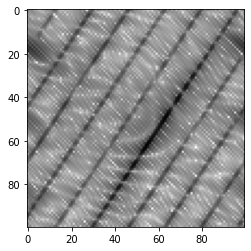

: 

In [136]:
plt.imshow(np.log(FTI[25]), cmap = 'Greys')